# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import unquote
import numpy as np

# To Extract all the URLs from the HTM page
from bs4 import BeautifulSoup
import os

import networkx as nx
from datetime import datetime

# Draw the graph
import seaborn as sns

from helpers import (
    extract_links,
    change_characters,
    path_to_name
    )   


# Preprocessing

## Downloading the dataset

In [2]:
# Paths
folder_path = "dataset/wikispeedia_paths-and-graph/"
file_paths = ["paths_finished.tsv", "paths_unfinished.tsv", "categories.tsv", "articles.tsv", "links.tsv"]

# Datasets: Names and their columns name
data_frames_names = ["paths_finished", "paths_unfinished", "categories", "article", "links"]
dfs_headers = [
    ["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
    ["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
    ["article", "category"],
    ["article"],
    ["linkSource", "linkTarget"]
]

# Download
dfs_skiprows = [16, 17, 13, 12, 12]
dfs = {}
for i in range(len(file_paths)):
    dfs[data_frames_names[i]] = pd.read_csv(folder_path + file_paths[i], sep='\t', header=None, names=dfs_headers[i], skiprows=range(dfs_skiprows[i]))

## Functions

In [3]:
def dataset_info(dictionary, dataset_name):
    """ Display main information about a specified dataset from the given dictionary.
    params:
        dictionnary: dict
            A dictionary of dataframes.
        dataset_name: str 
            The name of the dataframe to be accessed in the dictionary
     """
    # Print the dataset name we are working on
    print('{}:'.format(dataset_name))

    df = dictionary[dataset_name]
    print('\tShape of the dataset: {}'.format(df.shape))
    

     # Check for NaN values in each column
    columns_with_nan = df.columns[df.isna().any()].tolist()

    # Print the columns with NaN values if they exsit
    if columns_with_nan == []:
        print('\tThe dataset has no column with NaN values.\n')
    else:
        print('\tThe dataset has {} columns with NaN values: {}\n'.format(len(columns_with_nan), columns_with_nan))
    
    # Provide statistical info 
    print('Visualisation of the first column and statistical infos:')
    display(df.head(1))
    display(df.describe(include='all'))
    df.info()

## Format & missing values

### Finished paths dataset

In [4]:
dataset_info(dfs, 'paths_finished')

paths_finished:
	Shape of the dataset: (51318, 5)
	The dataset has 2 columns with NaN values: ['hashedIpAddress', 'rating']

Visualisation of the first column and statistical infos:


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN


,hashedIpAddress,timestamp,durationInSec,path,rating
count,51315,5.131800e+04,51318.000000,51318,28501.000000
unique,14244,NaN,NaN,47856,NaN
top,0d57c8c57d75e2f5,NaN,NaN,Brain;Computer_science;Information;Communicati...,NaN
freq,4865,NaN,NaN,144,NaN
mean,NaN,1.296384e+09,158.276199,NaN,2.269780
std,NaN,4.935086e+07,360.841904,NaN,1.110439
min,NaN,1.219095e+09,0.000000,NaN,1.000000
25%,NaN,1.250109e+09,60.000000,NaN,1.000000
50%,NaN,1.283894e+09,107.000000,NaN,2.000000
75%,NaN,1.345231e+09,183.000000,NaN,3.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51318 entries, 0 to 51317
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hashedIpAddress  51315 non-null  object 
 1   timestamp        51318 non-null  int64  
 2   durationInSec    51318 non-null  int64  
 3   path             51318 non-null  object 
 4   rating           28501 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.0+ MB


#### Observations

- The *finish path* dataset consists of 5 columns: 
    - **hashedIpAddress:** The IP adresses that allows to identify different players. 
    - **timestamp:**  A sequence of characters indicating the current time of an event, in this case, playing Wikispeedia, recorded by the computer.
    - **durationInsec:** The duration it tooks for the player to link the source article to the target. 
    - **path:** Each path taken to link a source article to the target.
    - **rating:** An optional evaluation made by the player to assess the difficulty encountered in linking the source to the target article.

* From the count and unique information, the following observations can be made:
    * There are 14,244 unique hashedIpAddress out of 51,315 Ip addresses, meaning that the users are playing the game multiple times. 
    * Some players are taking the same path as there are 47,856 unique paths out of 51,318. 
    
- The dataset contains missing values in hashedIpAddress and rating columns. For our analysis, we will not use the information from those two columns, so handling missing values is not necessary for now. Therfore we will just remove those columns from the dataset for the further analysis. If needed, one option for handling missing values in hashedIpAddress is to remove corresponding rows, as only 3 out of 51,318 values are missing. For the rating missing values, around 55% of the values are missing, simply removing them may result in a significant reduction in the dataset size and introduce bias. A better approach would be to predict their values and replace the NaN entries with those predictions or replace NaN with another value manageable for the task at hand.

- We observed that in the path column, some characters are not correctly translated (%.. format). We need to correct them.

#### Adjustments

In [5]:
dfs = change_characters(dfs, 'paths_finished', 'path')
dfs['paths_finished'] = dfs['paths_finished'].drop(['hashedIpAddress', 'rating'], axis = 1)
display(dfs['paths_finished'])

,timestamp,durationInSec,path
0,1297740409,166,14th_century;15th_century;16th_century;Pacific...
1,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...
2,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...
3,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece
4,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...
...,...,...,...
51313,1349231015,66,Yagan;Ancient_Egypt;Civilization
51314,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...
51315,1385095372,228,Yagan;Australia;England;France;United_States;T...
51316,1298792567,56,"Yarralumla,_Australian_Capital_Territory;Austr..."


### Unfinished paths dataset

In [6]:
dataset_info(dfs, 'paths_unfinished')

paths_unfinished:
	Shape of the dataset: (24875, 6)
	The dataset has no column with NaN values.

Visualisation of the first column and statistical infos:


,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout


,hashedIpAddress,timestamp,durationInSec,path,target,type
count,24875,2.487500e+04,24875.000000,24875,24875,24875
unique,11485,NaN,NaN,20982,3766,2
top,26f76e394525328e,NaN,NaN,Brain,Telephone,restart
freq,163,NaN,NaN,213,1060,15552
mean,NaN,1.344763e+09,835.296884,NaN,NaN,NaN
std,NaN,2.772317e+07,881.287961,NaN,NaN,NaN
min,NaN,1.297055e+09,4.000000,NaN,NaN,NaN
25%,NaN,1.320339e+09,86.000000,NaN,NaN,NaN
50%,NaN,1.348587e+09,261.000000,NaN,NaN,NaN
75%,NaN,1.367373e+09,1831.000000,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24875 entries, 0 to 24874
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   hashedIpAddress  24875 non-null  object
 1   timestamp        24875 non-null  int64 
 2   durationInSec    24875 non-null  int64 
 3   path             24875 non-null  object
 4   target           24875 non-null  object
 5   type             24875 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


#### Observations

- The *unfinish path* dataset consists of 6 columns: 
    - **hashedIpAddress:** The IP adresses that allows to identify different players. 
    - **timestamp:**  A sequence of characters indicating the current time of an event, in this case, playing Wikispeedia, recorded by the computer.
    - **durationInsec:** The duration it tooks for the player to link the source article to the target. 
    - **path:** Each path taken to link a source article to the target.
    - **target:** The name of the target article the player would ideally reach.
    - **type:** The reason for which the path is unfinished, categorized into two types: timeout and restart.

* From the count and unique information, the following observations can be made:
    * There as for the finished paths, since there is a smaller number of unique hashedIpAddress than the total count, we can conclude that users are playing the game multiple times. 
    * Some players are taking the same path. The most represented unfinished path is *brain* (a path consisting of only one article), implying that some unfinished paths may result from players that do not like the source and target combination and choosing to restart.
    
 - There are no missing values. 

- We observed that in the path and target columns, some characters are not correctly translated (%.. format). We need to correct them.

#### Adjustments

In [7]:
dfs = change_characters(dfs, 'paths_unfinished', 'path')
dfs = change_characters(dfs, 'paths_unfinished', 'target')
display(dfs['paths_unfinished'])

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
...,...,...,...,...,...,...
24870,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,Cholera,restart
24871,232f992e57d43e8d,1389787697,6,Modern_history,Hollandic,restart
24872,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,The_Beatles,timeout
24873,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,Alan_Turing,timeout


### Categories dataset

In [8]:
dataset_info(dfs, 'categories')

categories:
	Shape of the dataset: (5204, 2)
	The dataset has no column with NaN values.

Visualisation of the first column and statistical infos:


,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...


,article,category
count,5204,5204
unique,4598,129
top,Pottery,subject.Countries
freq,3,229


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5204 entries, 0 to 5203
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   5204 non-null   object
 1   category  5204 non-null   object
dtypes: object(2)
memory usage: 81.4+ KB


#### Observations

- The _categories_ dataset consists of 2 columns: 
    - **article:** The name of the article.
    - **category:**  The corresponding categories to which the articles belong. The category is a sequence of sub-categories separated by a point.

* From the count and unique information, the following observations can be made:
    * There are 4,598 unique articles out of 5,204, meanings some articles have more than one category path within the 129 possible. 
    
 - There are no missing values. 

- We observed that in the article columns, some characters are not correctly translated (%.. format). We need to correct them. To be sure there are no similar issues in the category column, we will also check and correct them.


#### Adjustments

In [9]:
dfs = change_characters(dfs, 'categories', 'article')
dfs = change_characters(dfs, 'categories', 'category')
display(dfs['categories'])

,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists
...,...,...
5199,Zirconium,subject.Science.Chemistry.Chemical_elements
5200,Zoroaster,subject.People.Religious_figures_and_leaders
5201,Zuid-Gelders,subject.Geography.European_Geography
5202,Zuid-Gelders,subject.Language_and_literature.Languages


### Article dataset

In [10]:
dataset_info(dfs, 'article')

article:
	Shape of the dataset: (4604, 1)
	The dataset has no column with NaN values.

Visualisation of the first column and statistical infos:


,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in


,article
count,4604
unique,4604
top,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
freq,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4604 entries, 0 to 4603
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  4604 non-null   object
dtypes: object(1)
memory usage: 36.1+ KB


#### Observations

- The _article_ dataset consists of 1 column: 
    - **article:** The name of the article.

* There are 6,604 articles and no missing values.
    
- We observed that in the article columns, some characters are not correctly translated (%.. format). We need to correct them.

#### Adjustments


In [11]:
dfs = change_characters(dfs, 'article', 'article')
display(dfs['article'])


,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts
...,...
4599,Zionism
4600,Zirconium
4601,Zoroaster
4602,Zuid-Gelders


### Links dataset

In [12]:
dataset_info(dfs, 'links')

links:
	Shape of the dataset: (119882, 2)
	The dataset has no column with NaN values.

Visualisation of the first column and statistical infos:


,linkSource,linkTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede


,linkSource,linkTarget
count,119882,119882
unique,4587,4135
top,United_States,United_States
freq,294,1551


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119882 entries, 0 to 119881
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   linkSource  119882 non-null  object
 1   linkTarget  119882 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


#### Observations

- The _links_ dataset consists of 2 columns: 
    - **linkSource:** The name of the source article.
    - **linkTarget:** The name of the target article.

* From the summary information, the following observations are be made:
    * The most represented source and target articles is in both case the _United_States_ article. 
    * There are no missing values. 

- We observed that in both columns, some characters are not correctly translated (%.. format). We need to correct them. 

#### Adjustments

In [13]:
dfs = change_characters(dfs, 'links', 'linkSource')
dfs = change_characters(dfs, 'links', 'linkTarget')
display(dfs['links'])

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
...,...,...
119877,Zulu,South_Africa
119878,Zulu,Swaziland
119879,Zulu,United_Kingdom
119880,Zulu,Zambia


## Pre-processing function for further analysis
A function summarizing the above preprocessing steps can be found in the [helpers.py](helpers.py) Python script. This function will be used in the further analysis.

# Extract people data

In [14]:
categories = dfs['categories']

# Selection of all the articles from a people category
all_people_selection = categories[categories['category'].str.contains('People')]

# Separate the data as people that are main or secondary people
main_people_selection = all_people_selection[all_people_selection['category'].str.contains('subject.People')]
second_people_selection = pd.concat([main_people_selection,all_people_selection]).drop_duplicates(keep=False)

# Verify that all the articles are unique
all_people_selection.info() 
main_people_selection.info()
second_people_selection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 1 to 5200
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   711 non-null    object
 1   category  711 non-null    object
dtypes: object(2)
memory usage: 16.7+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 689 entries, 1 to 5200
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   689 non-null    object
 1   category  689 non-null    object
dtypes: object(2)
memory usage: 16.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 250 to 4806
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   22 non-null     object
 1   category  22 non-null     object
dtypes: object(2)
memory usage: 528.0+ bytes


In [15]:
#Look at the people data set
display(main_people_selection.head())
display(second_people_selection.head())

,article,category
1,Áedán_mac_Gabráin,subject.People.Historical_figures
4,Édouard_Manet,subject.People.Artists
8,Óengus_I_of_the_Picts,subject.People.Historical_figures
67,A._E._J._Collins,subject.People.Sports_and_games_people
88,Abbas_I_of_Persia,subject.People.Historical_figures


,article,category
250,Amish,subject.Geography.Peoples
318,Anthropology,subject.Geography.Peoples
467,Azerbaijani_people,subject.Geography.Peoples
679,Black_Seminoles,subject.Geography.Peoples
1208,Crimean_Karaites,subject.Geography.Peoples


- We can observe here that the 2nd people selection doesn't design person but communities and population.
- Now we want to verify whether some person are not in the people category and we missed them. 

In [16]:
individual_category = categories.category.str.split('.').explode().unique()
print('There are {} categories.'.format(len(individual_category)-1))

There are 141 categories.


In [17]:
values_to_check = ['Historical_figures', 'Artists', 'Performers_and_composers', 'Geographers_and_explorers', 
                   'USA_Presidents', 'Religious_figures_and_leaders', 'Political_People', 'Producers_directors_and_media_figures',
                   'Engineers_and_inventors', 'Military_People', 'Monarchs_of_Great_Britain', 'Actors_models_and_celebrities', 
                   'Philosophers', 'Human_Scientists', 'Computing_People'
                   ] # without Divinities

a = categories[categories['category'].str.contains('|'.join(values_to_check))]
b = a[a['category'].str.contains('subject.People' )]
not_labelled_people_selection = pd.concat([a,b]).drop_duplicates(keep=False)
not_labelled_people_selection

,article,category
69,AC_DC,subject.Music.Performers_and_composers
358,Arctic_Monkeys,subject.Music.Performers_and_composers
1417,Duran_Duran,subject.Music.Performers_and_composers
2444,Iron_Maiden,subject.Music.Performers_and_composers
2694,Ladysmith_Black_Mambazo,subject.Music.Performers_and_composers
2936,Magdalena_Abakanowicz,subject.Art.Artists
3066,McFly_(band),subject.Music.Performers_and_composers
3357,Niccolò_dell'Abbate,subject.Art.Artists
3380,Nirvana_(band),subject.Music.Performers_and_composers
3427,Oasis_(band),subject.Music.Performers_and_composers


We can notice that some people are not labelled as people. 
- For the music.Performers_and_composers: they are groups so it make sense.
- For the Art.Artits: Within this category, two of them are not labelled as subject.People.Artists but only subject.Artists : Niccolò_dell'Abbate & Magdalena_Abakanowicz. --> It is a mistake 

# Data distribution

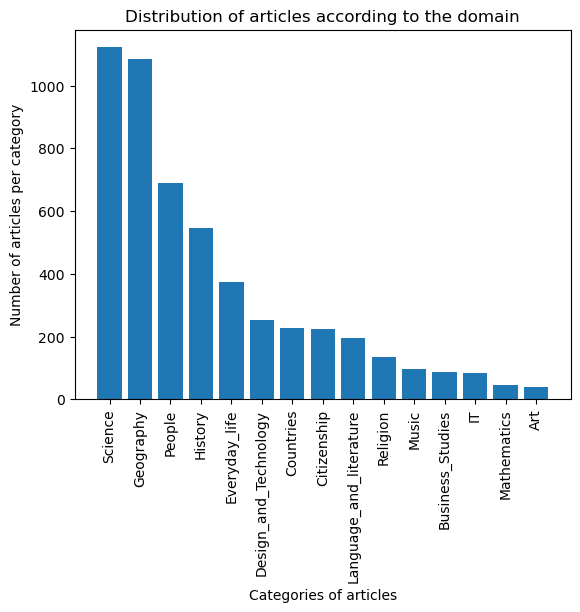

In [18]:
# First copy the data_frame
reduced_categories = categories.copy(deep=True)

# Extract the reduced categories and add them to the copied df
reduced_categories_list = [category.replace('subject.', '').split('.')[0] for category in reduced_categories['category']]
reduced_categories = reduced_categories.assign(simple_category = reduced_categories_list)

# Count the new distribution and plot it
category_distribution = reduced_categories['simple_category'].value_counts()

fig, ax = plt.subplots()
ax.bar(category_distribution.index, category_distribution.values)
ax.set_ylabel('Number of articles per category')
ax.set_xlabel('Categories of articles')
ax.set_xticks(np.arange(len(category_distribution.values)), category_distribution.index, rotation = 90)
ax.set_title('Distribution of articles according to the domain')
plt.show()


# Distribution of fame categories for people

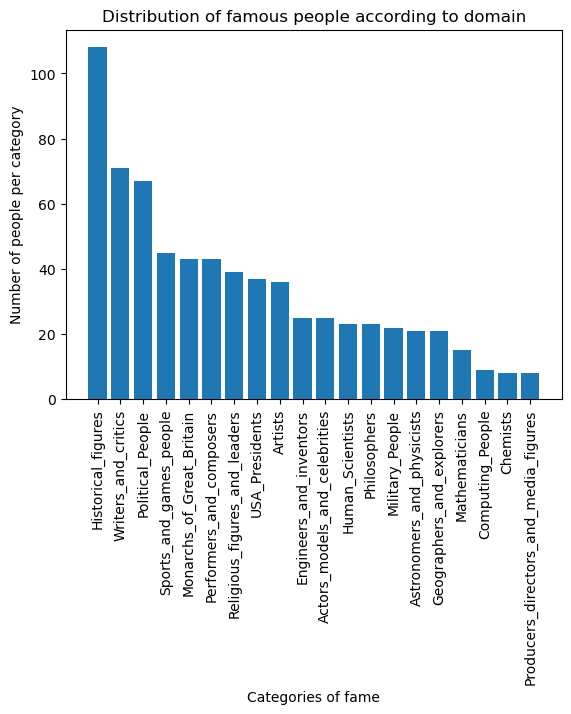

In [19]:
categories_distribution_df = main_people_selection['category'].value_counts()
categories_ = [category.replace('subject.People.', '') for category in categories_distribution_df.index]
cat_pos = np.arange(len(categories_))

fig, ax = plt.subplots()
ax.bar(cat_pos, categories_distribution_df.values)
ax.set_ylabel('Number of people per category')
ax.set_xlabel('Categories of fame')
ax.set_xticks(cat_pos, categories_, rotation = 90)
ax.set_title('Distribution of famous people according to domain')
plt.show()

## Distribution of the starting and finishing pages of the paths

In [20]:
paths_finished = dfs['paths_finished']

starting_points = pd.DataFrame([path.split(';')[0] for path in paths_finished['path']])
finishing_points = pd.DataFrame([path.split(';')[-1] for path in paths_finished['path']])

starting_counts = pd.DataFrame(starting_points.value_counts())
finishing_counts = pd.DataFrame(finishing_points.value_counts())

starting_list = [start[0] for start in starting_counts.index.tolist()]
finishing_list = [finish[0] for finish in finishing_counts.index.tolist()]

start_cat = [reduced_categories.loc[reduced_categories['article'] == start,'simple_category'].values.tolist() for start in starting_list]
finish_cat = [reduced_categories.loc[reduced_categories['article'] == finish,'simple_category'].values.tolist() for finish in finishing_list]

In [21]:
new_start_cat = start_cat
for i in range(len(start_cat)):
    if len(start_cat[i])>1:
        new_start_cat[i] = [start_cat[i][0]]
new_start_cat = [' '.join(cat) for cat in new_start_cat]

new_finish_cat = finish_cat
for i in range(len(finish_cat)):
    if len(finish_cat[i])>1:
        new_finish_cat[i] = [finish_cat[i][0]]
new_finish_cat = [' '.join(cat) for cat in new_finish_cat]

starting_counts = starting_counts.assign(simple_category = new_start_cat)
finishing_counts = finishing_counts.assign(simple_category = new_finish_cat)

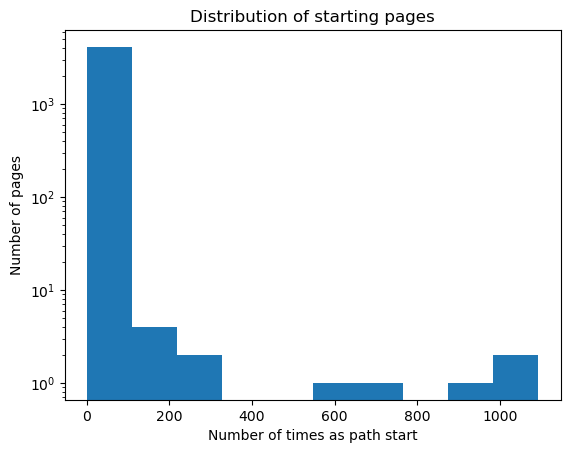

In [22]:
plt.hist(starting_counts['count'], 10)
plt.xlabel('Number of times as path start')
plt.ylabel('Number of pages')
plt.title('Distribution of starting pages')
plt.yscale('log')
plt.show()

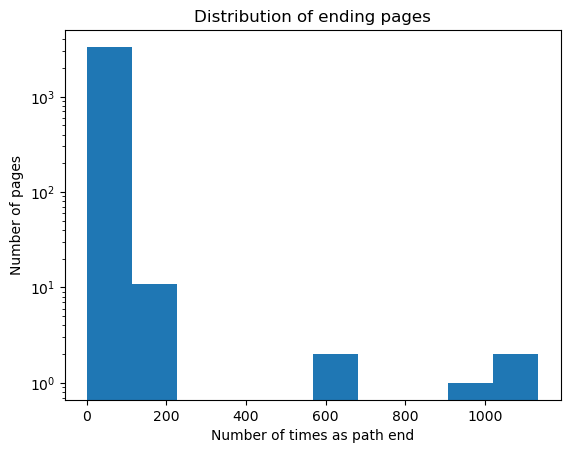

In [23]:
plt.hist(finishing_counts['count'], 10)
plt.xlabel('Number of times as path end')
plt.ylabel('Number of pages')
plt.title('Distribution of ending pages')
plt.yscale('log')
plt.show()

In [24]:
starting_counts_condensed = starting_counts.groupby(starting_counts['simple_category']).aggregate('count')
finishing_counts_condensed = finishing_counts.groupby(finishing_counts['simple_category']).aggregate('count')

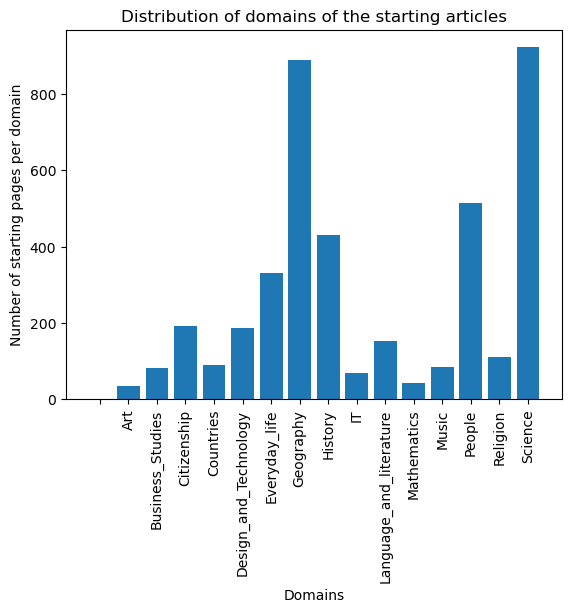

In [25]:
fig, ax = plt.subplots()
ax.bar(starting_counts_condensed.index, starting_counts_condensed['count'])
ax.set_ylabel('Number of starting pages per domain')
ax.set_xlabel('Domains')
ax.set_xticks(np.arange(len(starting_counts_condensed.index)),starting_counts_condensed.index, rotation = 90)
ax.set_title('Distribution of domains of the starting articles')
plt.show()

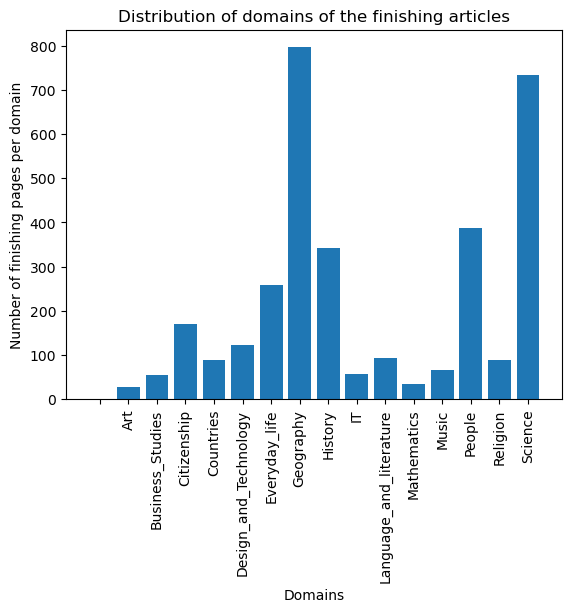

In [26]:
fig, ax = plt.subplots()
ax.bar(finishing_counts_condensed.index, finishing_counts_condensed['count'])
ax.set_ylabel('Number of finishing pages per domain')
ax.set_xlabel('Domains')
ax.set_xticks(np.arange(len(finishing_counts_condensed.index)),finishing_counts_condensed.index, rotation = 90)
ax.set_title('Distribution of domains of the finishing articles')
plt.show()

# Connection graphs of the links

#### List of paths to access the articles htm

In [27]:
list_articles_paths = []

# Iterate through all htm file in all sub-folder from main folder wp 
for root, dirs, subfolders in os.walk('dataset/wpcd/wp/'):
    for file in subfolders:
        # Select only the htm files
        if file.endswith('.htm'):
            file_path = os.path.join(root, file)
            # Store only select the htm usefull for the game 
            if 'index' not in file_path:
                list_articles_paths.append(file_path)
list_articles_paths[:10]

['dataset/wpcd/wp/r/Royal_Marines.htm',
 'dataset/wpcd/wp/r/Recycling.htm',
 'dataset/wpcd/wp/r/Retreat_of_glaciers_since_1850.htm',
 'dataset/wpcd/wp/r/Remember_Girls_Like_Rajpura.htm',
 'dataset/wpcd/wp/r/Rutherfordium.htm',
 'dataset/wpcd/wp/r/Rule_of_St_Benedict.htm',
 'dataset/wpcd/wp/r/Red_dwarf.htm',
 'dataset/wpcd/wp/r/Romeo_and_Juliet.htm',
 'dataset/wpcd/wp/r/Rudyard_Kipling.htm',
 'dataset/wpcd/wp/r/Race.htm']

# Connection graphs of graphs

In [28]:
def connection_graph(html_files, nodes_name, categories, people_names,  fs = (15, 10), node_sz=20, font_sz=12, color_pal = "colorblind", title = '', directional = False, label = False,  people = False, plot = True):
    start_time = datetime.now()

    category_table = categories.copy()

    # Create a graph
    if directional: 
        graph = nx.MultiDiGraph()
    else:
        graph = nx.MultiGraph()

    # Iterate through HTML files and extract links
    for html_file in html_files: 
        # Extract all the unique link of the htm file
        links = extract_links(html_file)

        # Extract the source article name
        source_name = path_to_name(html_file)

        if not people:
            for link in set(links):
                # Extract the reached article name
                target_name = path_to_name(link)

                # Add edges to the graph
                graph.add_edge(source_name, target_name)

        # In case we only want people names pages      
        elif source_name in people_names:
            for link in set(links):
                # Extract the reached article name
                target_name = path_to_name(link)

                # Add edges to the graph
                graph.add_edge(source_name, target_name)
    
    # Add category to the nodes
    nodes = pd.Series(list(graph.nodes))
    art_cat = pd.merge(category_table, nodes.rename('article'), how='right', on='article')
    art_cat['category'].fillna('unkown', inplace=True)
    graph.add_nodes_from(art_cat.article)
    
    # Colors corresponding to the categories 
    colors = sns.color_palette(color_pal, n_colors=len(art_cat.category.unique()))
    category_color_dict = {category: colors[i] for i, category in enumerate(art_cat['category'].unique())}
    node_colors = [category_color_dict[category] for category in art_cat['category']]

    
    # Plot or not
    if plot: 

        plt.figure(figsize=fs)

        pos = nx.spring_layout(graph) 
        #nx.draw(graph, pos, with_labels=label, node_color=node_colors,  node_size=node_sz, font_size=font_sz, edge_color='black', alpha=0.5)

        nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=node_sz)

        # Draw the edges with another alpha value
        nx.draw_networkx_edges(graph, pos, alpha=0.5)

        if label:
            # Draw labels separately without alpha
            nx.draw_networkx_labels(graph, pos, font_size=font_sz)

        # Legend 
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in category_color_dict.values()]
        labels = [str(category) for category in category_color_dict.keys()]
        plt.legend(handles, labels, title='Categories', loc = 'upper left', bbox_to_anchor=(1, 1))  
        plt.title(title)
        plt.axis('off')

        plt.show()
    
    else:
        print('Duration create_connection_graph for {} html files: {}'.format(len(html_files), datetime.now() - start_time))
        return graph, node_colors

In [29]:
main_categories = dfs['categories'].copy()

# Selection of the article list of people
people_list = main_categories.copy()[main_categories['category'].str.contains('subject.People')]
people_list = list(people_list.article)

# Main categories of all articles 
main_categories.category = [cat.split('.')[1] for cat in main_categories.category]
# Some of them have two main categories, for now I just select the first one that appear 
main_categories = main_categories.groupby('article')['category'].first().reset_index()

# Color selection for all the main categories
color_ = ["#F3C300", "#875692", "#F38400", "#A1CAF1", "#BE0032", "#C2B280", "#848482" ,"#008856", "#E68FAC", "#0067A5" ,"#F99379" ,"#604E97", "#F6A600" ,"#B3446C", "#DCD300", "#882D17", "#8DB600" ,"#654522","#E25822" ,"#2B3D26"]


### Article graphs

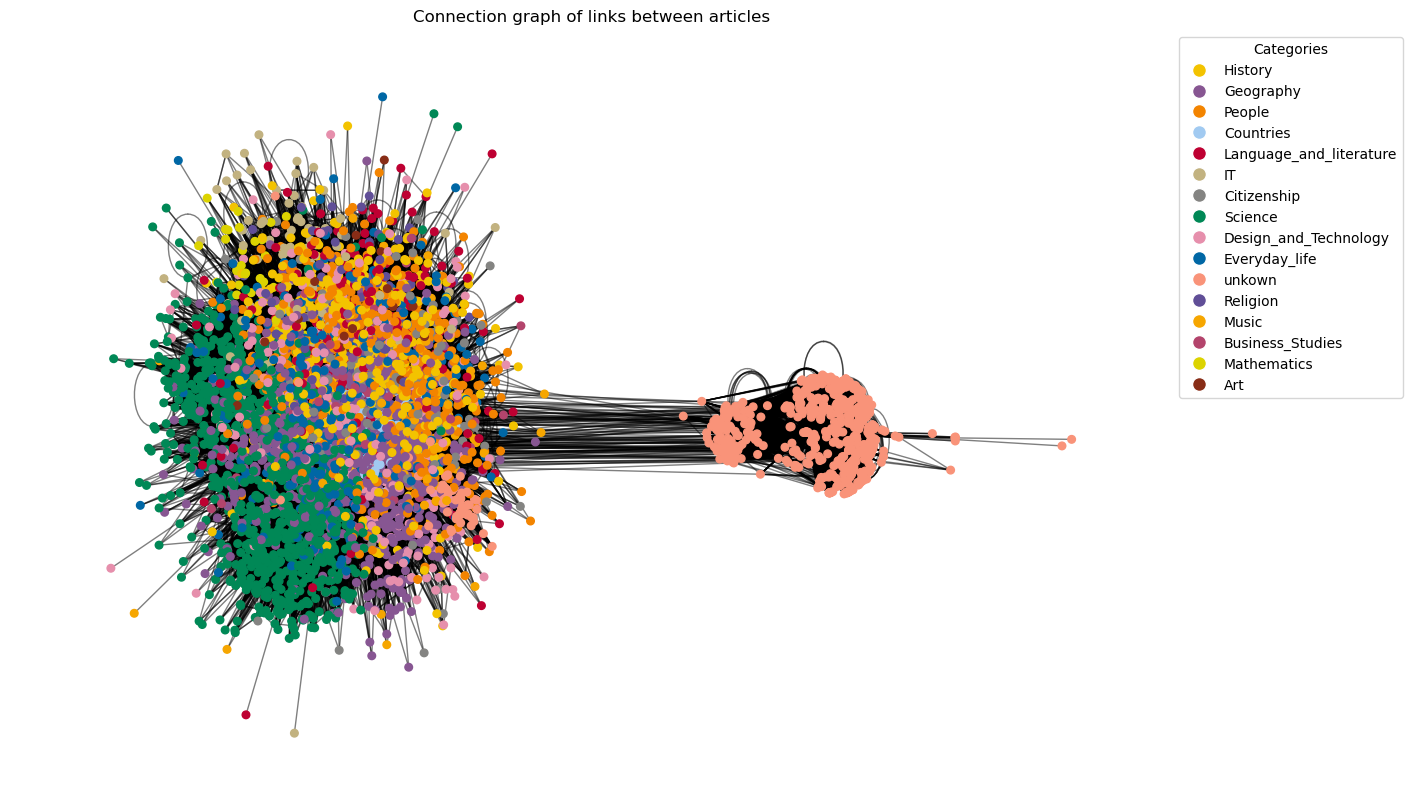

In [30]:
connection_graph(list_articles_paths, dfs['article']['article'], main_categories, 0, (15,10), node_sz=30, font_sz=12 , 
                        color_pal = color_, title = 'Connection graph of links between articles', directional = False, label = False,  people = False, plot = True)

Due to the large number of articles used, it is difficult to observe specific things. At least, we can observed that most article are linked together. A small cluster of unkown categories can be observed. 

### People article graphs 

Connection graph of the links from 2 famous people pages (Richard Wagner & Rudyard Kipling).


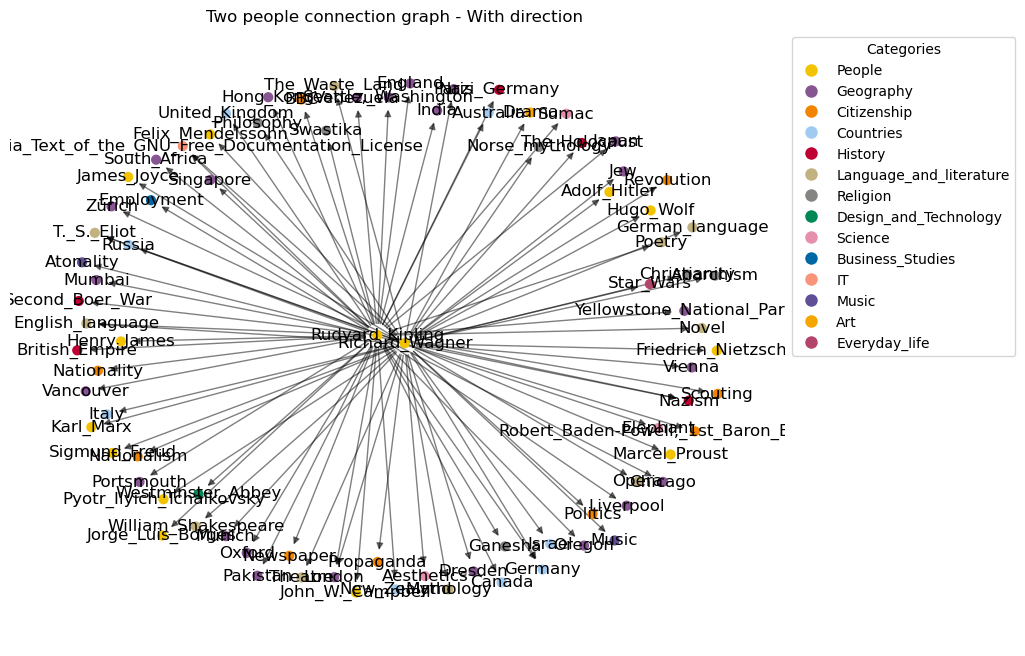

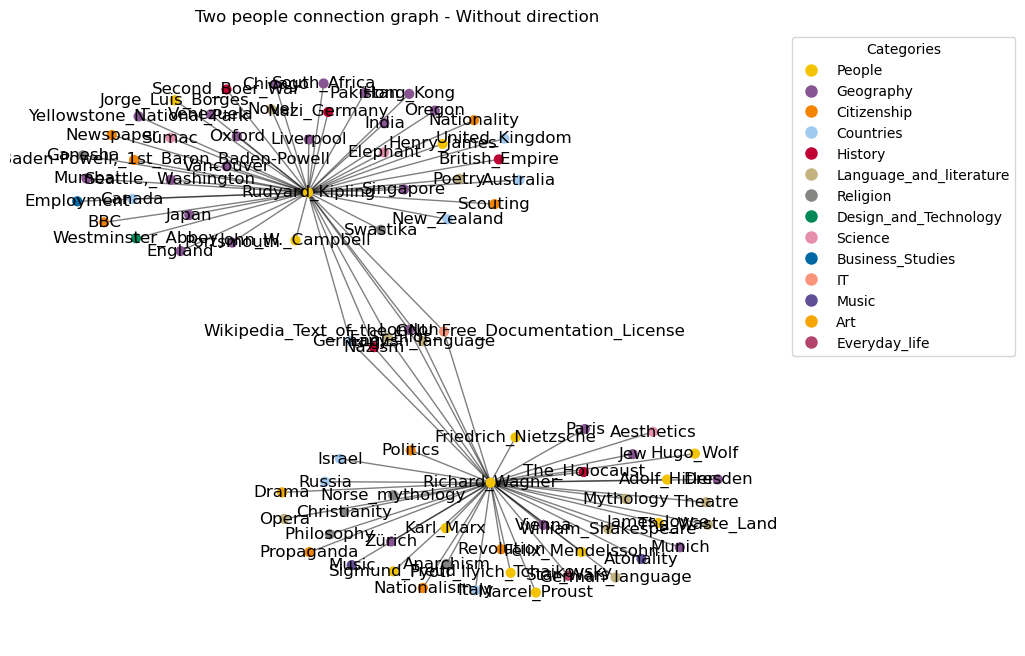

In [31]:

print('Connection graph of the links from 2 famous people pages (Richard Wagner & Rudyard Kipling).')
connection_graph(list_articles_paths[:18], dfs['article']['article'], main_categories, people_list, (10,8), node_sz=40, font_sz=12 , 
                        color_pal = color_, title = 'Two people connection graph - With direction ', directional = True, label = True,  people = True, plot = True)

connection_graph(list_articles_paths[:18], dfs['article']['article'], main_categories, people_list, (10,8), node_sz=40, font_sz=12 , 
                        color_pal = color_, title = 'Two people connection graph - Without direction', directional = False, label = True,  people = True, plot = True)

Here, we have a visualisation of the links present in the page of two people. Even for a small number of page, with the name of the nodes (articles), it is difficult to read. We are interested to see if some cluster of domain are observed, so we will only look at the categories and not the article names. 

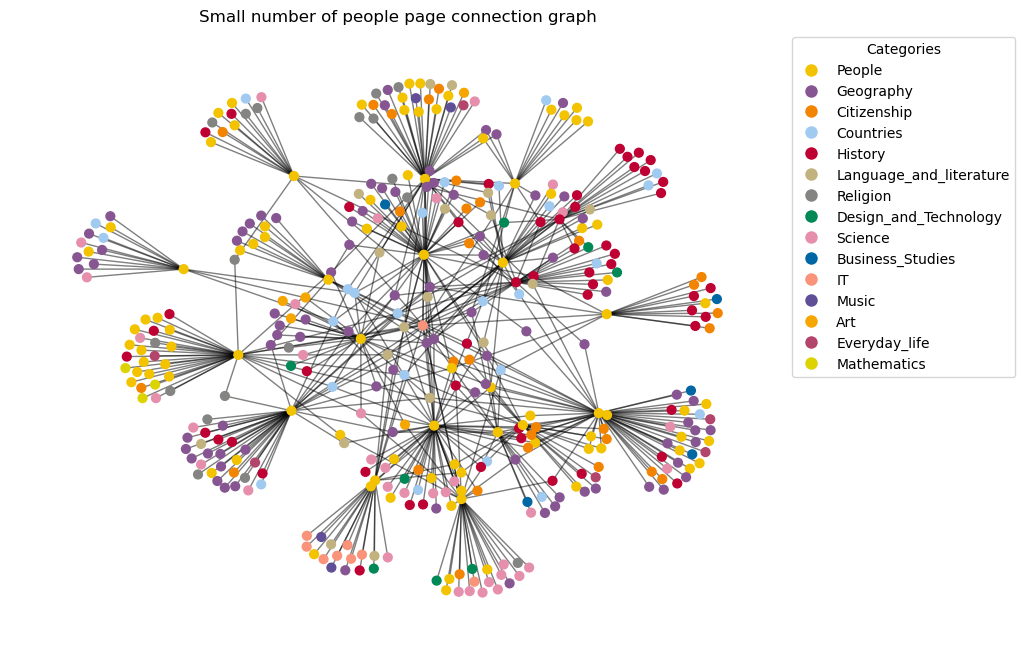

In [32]:
connection_graph(list_articles_paths[:100], dfs['article']['article'], main_categories, people_list, (10,8), node_sz=40, font_sz=12 , 
                        color_pal = color_, title = 'Small number of people page connection graph', directional = False, label = False,  people = True, plot = True)

By incresing the number of people pages, we can start to notice some distinctions. By instance, some peoples seem more to be related to people than others. 

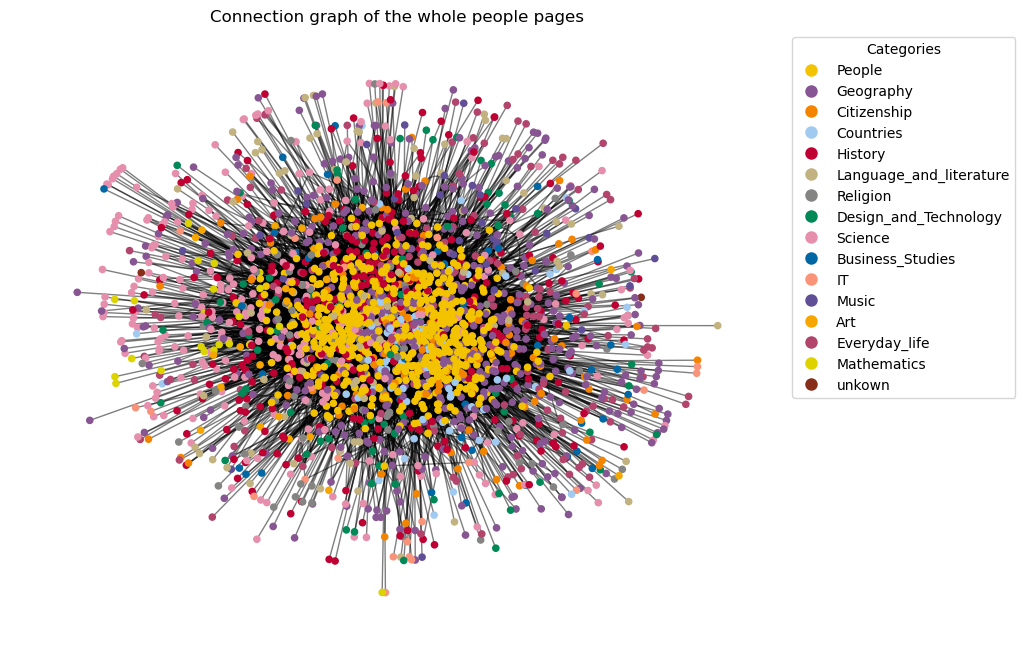

In [33]:
connection_graph(list_articles_paths, dfs['article']['article'], main_categories, people_list, (10,8) , 
                        color_pal = color_, title = 'Connection graph of the whole people pages', directional = False, label = False,  people = True, plot = True)

As for the whole article plot, extracting information from the links across all people's pages is difficult due to the large number of points (require an interactive connection graph). However, at least we can observe the absence of clusters of domains.